In [28]:
import pandas as pd
import warnings
import numpy as np
import yfinance as yf
import datetime as dt
import scipy
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore', category=FutureWarning) #ignores the PD futurewarnings they can get annoying
pd.options.mode.chained_assignment = None

Data grabbing functions

In [29]:
def options_chain(symbol):

    tk = yf.Ticker(symbol)
    # Expiration dates
    exps = tk.options

    # Get options for each expiration
    options = pd.DataFrame()
    for e in exps:
        opt = tk.option_chain(e)
        opt = pd.DataFrame().append(opt.calls).append(opt.puts)
        opt['expirationDate'] = e
        options = options.append(opt, ignore_index=True)

    # Boolean column if the option is a CALL
    options['CALL'] = options['contractSymbol'].str[4:].apply(
        lambda x: "C" in x)

    options[['bid', 'ask', 'strike']] = options[['bid', 'ask', 'strike']].apply(pd.to_numeric)
    options['midprice'] = (options['bid'] + options['ask']) / 2 # Calculate the midpoint of the bid-ask

    # Drop unnecessary and meaningless columns
    options = options.drop(columns = ['contractSize', 'currency', 'change', 'percentChange', 'lastTradeDate', 'lastPrice'])

    return options
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

Variables

In [30]:
stock = 'SPY'
S = int(get_current_price(stock))

today = dt.datetime.today().strftime('%Y-%m-%d')
# exp is target date for single option analysis. start_date is the date to start range analysis, end date is the end of the range
exp = '2022-5-6'
start_date = today
end_date = '2022-6-17'

Grabbing the data and saving as CSV (optional step - I like to keep the data over time)

In [31]:
options = options_chain(stock)
options.to_csv(fr'C:\Users\Connor\Desktop\Fresh\options\{stock}\{stock}out, ({today}).csv')
options = options.dropna()

Processing the data

In [32]:
options = options.rename(columns={'impliedVolatility':'iv'}) #renaming impliedVol to iv because easier to type
options['expirationDate'] = pd.to_datetime(options['expirationDate']) #expdate str to dt
options['DTE'] = options.expirationDate - dt.datetime.today() #adding days to expiration
options['DTE'] = pd.to_numeric(options['DTE'].dt.days, downcast='integer') #getting as day int
options['DTE'] = options['DTE'] + 1
options = options[options.expirationDate == exp]

Seperating puts and calls and adding moneyness column

In [33]:
calls = options[options.CALL == True]
puts = options[options.CALL == False]
calls['Moneyness'] = (( S - calls.strike ) / S ) * 100 #Adding % out/in the money column (moneyness)
puts['Moneyness'] = (( puts.strike - S ) / S ) * 100

Creating butterfly dataframes for calls from https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

In [34]:
data_calls = []

for (_, left) ,(_,centre), (_, right) in zip(calls.iterrows(), calls.iloc[1:].iterrows(), calls.iloc[2:].iterrows()):
    # Filter out all zero volume
    if not any(vol > 2 for vol in {left.volume, centre.volume, right.volume}):
        continue
    # Filter out any zero open interest
    if not all(oi > 2 for oi in {left.openInterest, centre.openInterest, right.openInterest}):
        continue
    # Equidistant on either end
    if centre.strike - left.strike != right.strike - centre.strike:
        continue
    butterfly_price = left.midprice - 2* centre.midprice + right.midprice
    max_profit = centre.strike - left.strike
    data_calls.append([centre.strike, butterfly_price, max_profit])

call_bflys = pd.DataFrame(data_calls, columns=["strike", "price", "max_profit"])
call_bflys["prob"] = call_bflys.price / call_bflys.max_profit
smoothed_prob_call = gaussian_filter1d(call_bflys.prob, 2)
call_pdf = scipy.interpolate.interp1d(call_bflys.strike, smoothed_prob_call, kind="cubic",
                                 fill_value="extrapolate")

Creating butterfly dataframes for puts

In [35]:
data_puts = []

for (_, left) ,(_,centre), (_, right) in zip(puts.iterrows(), puts.iloc[1:].iterrows(), puts.iloc[2:].iterrows()):
    # Filter out all zero volume
    if not any(vol > 2 for vol in {left.volume, centre.volume, right.volume}):
        continue
    # Filter out any zero open interest
    if not all(oi > 2 for oi in {left.openInterest, centre.openInterest, right.openInterest}):
        continue
    # Equidistant on either end
    if centre.strike - left.strike != right.strike - centre.strike:
        continue
    butterfly_price = left.midprice - 2* centre.midprice + right.midprice
    max_profit = centre.strike - left.strike
    data_puts.append([centre.strike, butterfly_price, max_profit])

put_bflys = pd.DataFrame(data_puts, columns=["strike", "price", "max_profit"])
put_bflys["prob"] = put_bflys.price / put_bflys.max_profit
smoothed_prob_put = gaussian_filter1d(put_bflys.prob, 2)
put_pdf = scipy.interpolate.interp1d(put_bflys.strike, smoothed_prob_put, kind="cubic",
                                     fill_value=0.0)

Creating the combined PDF of market expectations https://reasonabledeviations.com/2020/10/01/option-implied-pdfs/

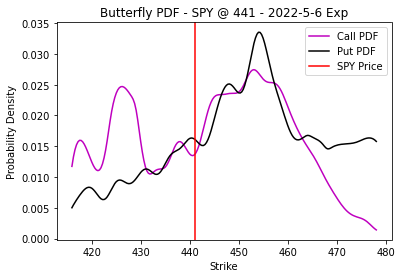

In [36]:
x_new = np.linspace(call_bflys.strike.min(), put_bflys.strike.max(), 200)

plt.title(f'Butterfly PDF - {stock} @ {S} - {exp} Exp')
plt.plot(x_new, call_pdf(x_new), "m-", x_new, put_pdf(x_new), "k-");
plt.axvline(S, color="r")
plt.legend(["Call PDF", "Put PDF", f"{stock} Price"], loc="best")
plt.xlabel("Strike")
plt.ylabel("Probability Density")
plt.show()

Graphing put and call prices w IV's

In [37]:
def price_iv(data,type):
    data_no_na = data.dropna()

    fig, (ax1, ax2) = plt.subplots(2,1, sharex = True)
    ax1.plot(data_no_na.strike, data_no_na.midprice, "r.")
    ax1.set_ylabel(f"{type} price")
    ax2.plot(data_no_na.strike, data_no_na.iv, ".")
    ax2.set_ylabel("IV")
    ax2.set_xlabel("Strike")
    plt.tight_layout()
    # plt.savefig("calls_to_iv.png", dpi=400)
    plt.show()

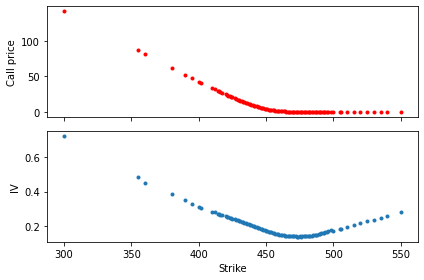

In [38]:
price_iv(calls, 'Call')

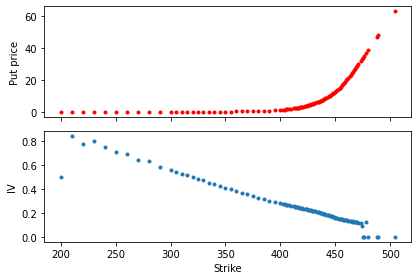

In [39]:
price_iv(puts, 'Put')

Seeing if current implied vol is due to higher recent realized vol

In [40]:
hist = yf.Ticker(stock).history(start = dt.datetime(2021,1,1), end = today) #downloading price history

In [41]:
log_returns = np.log(hist.Close/hist.Close.shift(1)).dropna()
daily_std = log_returns.std() #daily standard deviation of log returns
annualized_std = daily_std * np.sqrt(252)

In [42]:
window = 10
volatility = log_returns.rolling(window=window).std()*np.sqrt(window) #rolling window of volatility

Good way to see where volatility is at, and make informed decisions on price

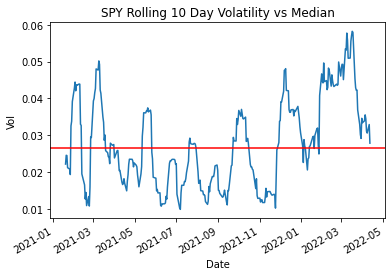

In [43]:
fig, ax = plt.subplots()
volatility.plot()
ax.set(xlabel = 'Date',
       ylabel= 'Vol',
       title = f'{stock} Rolling {window} Day Volatility vs Median')
plt.axhline(volatility.median(), color = 'r')

Creating Volatility Smiles to see IV premium

In [44]:
def vol_smile(data, type):
    data_clean = data.dropna().copy()
    data_clean["impliedVolatility"] = gaussian_filter1d(data_clean.iv, 3)
    plt.figure()

    vol_surface = scipy.interpolate.interp1d(data_clean.Moneyness, data_clean.impliedVolatility, kind="cubic",
                                     fill_value="extrapolate")
    x_new = np.arange(data_clean.Moneyness.min(), data_clean.Moneyness.max(), 0.1)

    plt.plot(data_clean.Moneyness, data_clean.impliedVolatility, "bx", x_new, vol_surface(x_new), "k-");
    plt.legend(["Smoothed IV", "Fitted Smile"], loc="best")
    plt.title(f'{stock} {type} IV Smile by Moneyness ({exp} Exp)')
    plt.xlabel("Moneyness (%)")
    plt.ylabel(f"{type} IV")
    plt.tight_layout()
    plt.show()

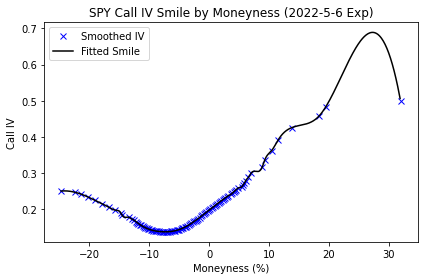

In [45]:
vol_smile(calls, 'Call')

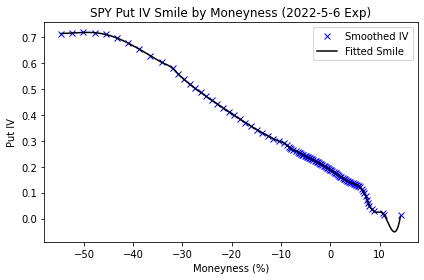

In [46]:
vol_smile(puts, 'Put')

Creating OI heatmap function to see what strikes have lots of activity

In [47]:
def oi_heatmap(start, end, flag):

    option_range = options_chain(stock) #grabbing fresh data then processing
    option_range = option_range.dropna()

    option_range['expirationDate'] = pd.to_datetime(option_range['expirationDate']) #expdate str to dt
    option_range['DTE'] = option_range.expirationDate - dt.datetime.today() #adding days to expiration
    option_range['DTE'] = pd.to_numeric(option_range['DTE'].dt.days, downcast='integer')
    option_range['DTE'] = option_range['DTE'] + 1

    option_range = option_range[(option_range['expirationDate'] >= start) & (option_range['expirationDate'] <= end)] #filtering to date range entered

    calls = option_range[option_range.CALL == True]
    puts = option_range[option_range.CALL == False]
    calls['Moneyness'] = (( S - calls.strike ) / S ) * 100
    puts['Moneyness'] = (( puts.strike - S ) / S ) * 100

    if flag == 'c':
        calls = calls[(calls.Moneyness <= 20) &(calls.Moneyness >= -20)] #filtering around ATM as further values are wonky
        calls = calls[['strike', 'DTE', 'openInterest']]
        calls = calls.pivot(index = 'strike', columns ='DTE', values ='openInterest').dropna() #wide form
        calls = calls.sort_index(ascending=False)


        #plotting
        sns.heatmap(calls, cbar = 'openInterest', cmap = 'coolwarm')
        plt.title(f'{stock} (${S}) Call open interest.')
        plt.xlabel('Days to Exp')
        plt.ylabel('Strike')

    elif flag == 'p':
        puts = puts[(puts.Moneyness <= 20) &(puts.Moneyness >= -20)]
        puts = puts[['strike', 'DTE', 'openInterest']]
        puts = puts.pivot(index = 'strike', columns ='DTE', values ='openInterest').dropna()
        puts = puts.sort_index(ascending=False)

        sns.heatmap(puts, cbar = 'openInterest', cmap = 'coolwarm')
        plt.title(f'{stock} (${S}) Put open interest.')
        plt.xlabel('Days to Exp')
        plt.ylabel('Strike')
    else:
        print('Enter appropriate flag (c,p)')

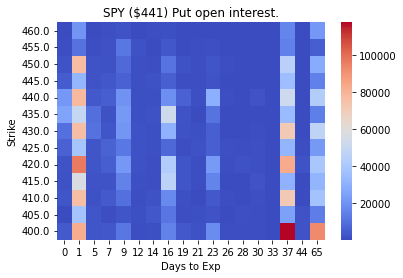

In [48]:
oi_heatmap(start_date, end_date, 'p')

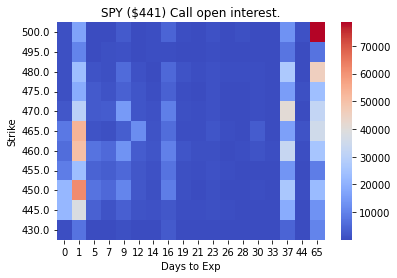

In [49]:
oi_heatmap(start_date, end_date, 'c')

Volume heatmap function - see where buying is happening

In [50]:
def volume_heatmap(start, end, flag):

    option_range = options_chain(stock) #grabbing fresh data then processing
    option_range = option_range.dropna()

    option_range['expirationDate'] = pd.to_datetime(option_range['expirationDate']) #expdate str to dt
    option_range['DTE'] = option_range.expirationDate - dt.datetime.today() #adding days to expiration
    option_range['DTE'] = pd.to_numeric(option_range['DTE'].dt.days, downcast='integer')
    option_range['DTE'] = option_range['DTE'] +1

    option_range = option_range[(option_range['expirationDate'] >= start) & (option_range['expirationDate'] <= end)] #filtering to date range entered

    calls = option_range[option_range.CALL == True]
    puts = option_range[option_range.CALL == False]
    calls['Moneyness'] = (( S - calls.strike ) / S ) * 100
    puts['Moneyness'] = (( puts.strike - S ) / S ) * 100

    if flag == 'c':
        calls = calls[(calls.Moneyness <= 20) &(calls.Moneyness >= -20)] #filtering around ATM as further values are wonky
        calls = calls[['strike', 'DTE', 'volume']]
        calls = calls.pivot(index = 'strike', columns ='DTE', values ='volume').dropna() #wide form
        calls = calls.sort_index(ascending=False)


        #plotting
        sns.heatmap(calls, cbar = 'volume', cmap = 'coolwarm')
        plt.title(f'{stock} (${S}) Call volume.')
        plt.xlabel('Days to Exp')
        plt.ylabel('Strike')

    elif flag == 'p':
        puts = puts[(puts.Moneyness <= 20) &(puts.Moneyness >= -20)]
        puts = puts[['strike', 'DTE', 'volume']]
        puts = puts.pivot(index = 'strike', columns ='DTE', values ='volume').dropna()
        puts = puts.sort_index(ascending=False)

        sns.heatmap(puts, cbar = 'volume', cmap = 'coolwarm')
        plt.title(f'{stock} (${S}) Put volume.')
        plt.xlabel('Days to Exp')
        plt.ylabel('Strike')
    else:
        print('Enter appropriate flag (c,p)')

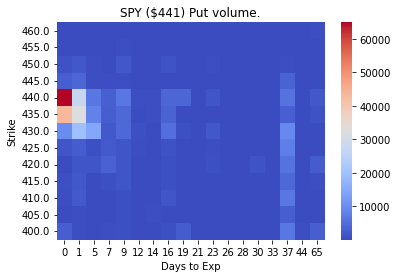

In [51]:
volume_heatmap(start_date, end_date, 'p')

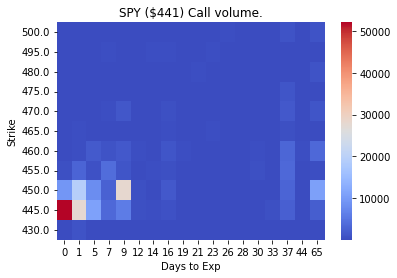

In [52]:
volume_heatmap(start_date, end_date, 'c')

In [55]:
hist['returns'] = hist.Close.pct_change() *100

<AxesSubplot:xlabel='Date'>

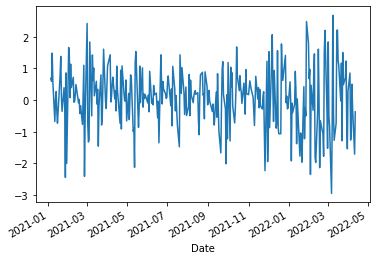

In [56]:
hist.returns.plot()